/tmp/ipython-input-1-1789096091.py:31: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  gdp = wb.download(country=countries, indicator='NY.GDP.MKTP.CD', start=year, end=year)
/tmp/ipython-input-1-1789096091.py:31: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  gdp = wb.download(country=countries, indicator='NY.GDP.MKTP.CD', start=year, end=year)
/tmp/ipython-input-1-1789096091.py:31: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  gdp = wb.download(country=countries, indicator='NY.GDP.MKTP.CD', start=year, end=year)


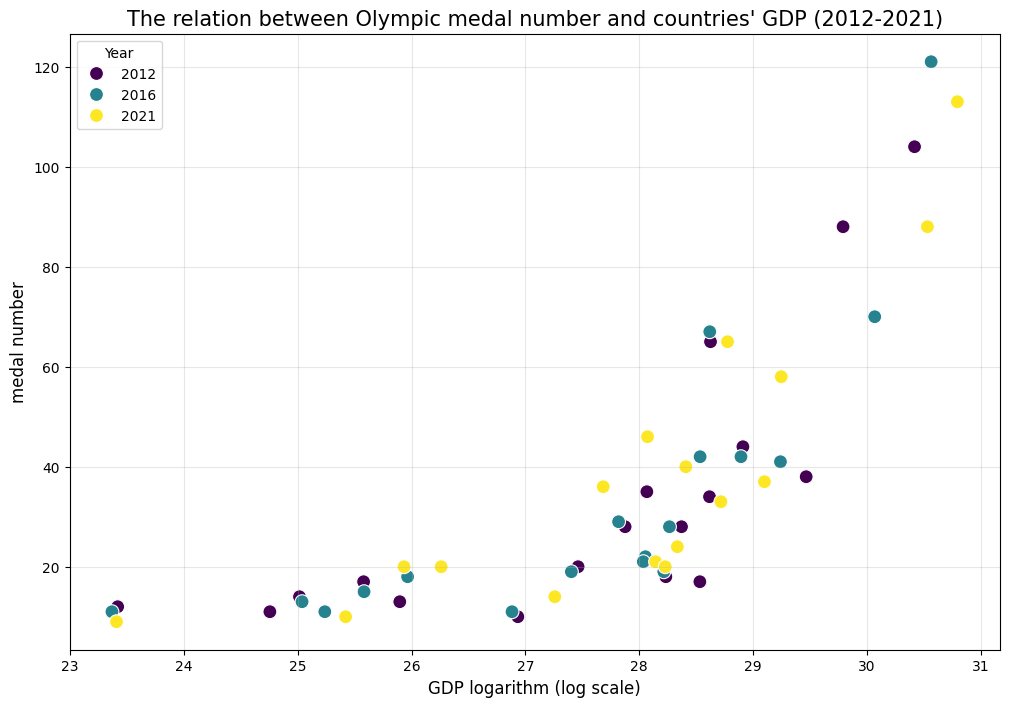

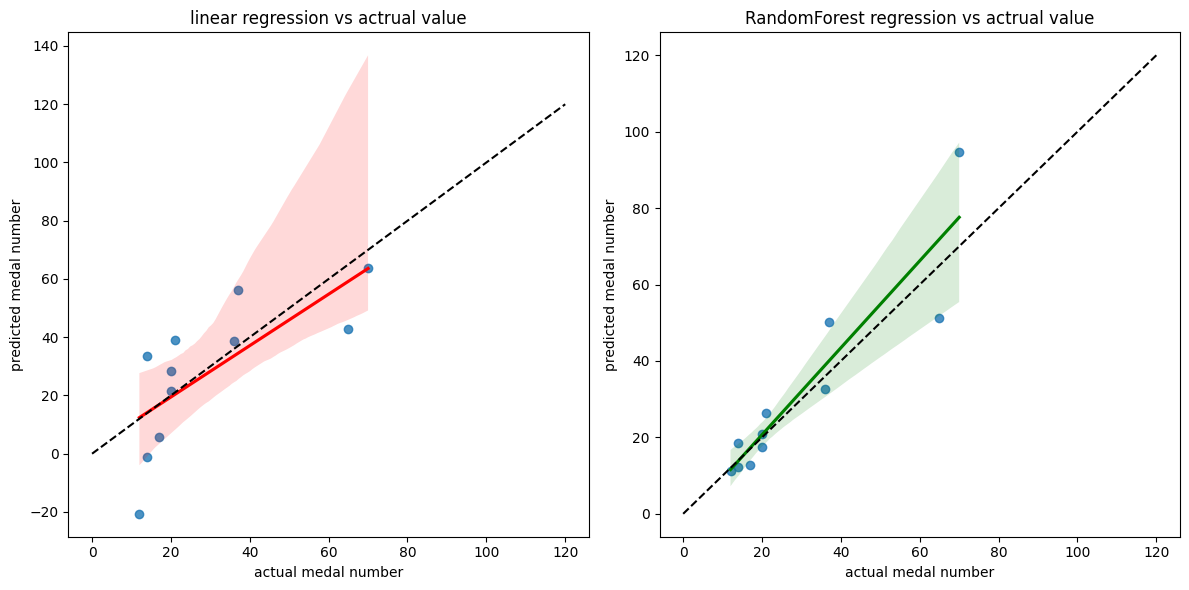

model           MAE        R²         accuracy  
---------------------------------------------
linear regression 14.32      0.2561     24.83%    
RandomForest    6.81       0.7491     80.00%    
\sample prediction result of the countries:
  Country  Predicted_Medals_LR  Predicted_Medals_RF
0     DEU            54.634020                52.80
1     IND            50.108248                46.87
2     BRA            45.562189                20.98


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from pandas_datareader import wb

# 1. medal data
olympic_data = {
    'Country': ['USA', 'CHN', 'JPN', 'GBR', 'AUS',
                'NLD', 'FRA', 'DEU', 'ITA', 'CAN', 'BRA', 'NZL',
                'CUB', 'HUN', 'KOR', 'POL', 'CZE', 'KEN', 'JAM'] * 3,
    'Year': [2012]*19 + [2016]*19 + [2021]*19,
    'Medals': [
        104, 88, 38, 65, 35, 20, 34, 44, 28, 18, 17, 13, 14, 17, 28, 10, 10, 11, 12,
        121, 70, 41, 67, 29, 19, 42, 42, 28, 22, 19, 18, 11, 15, 21, 11, 10, 13, 11,
        113, 88, 58, 65, 46, 36, 33, 37, 40, 24, 21, 20, 15, 20, 20, 14, 11, 10, 9
    ]
}
medals_df = pd.DataFrame(olympic_data)

# 2. gain GDP data
countries = medals_df['Country'].unique().tolist()
gdp_data = []

for year in [2012, 2016, 2021]:
    try:
        gdp = wb.download(country=countries, indicator='NY.GDP.MKTP.CD', start=year, end=year)
        gdp = gdp.reset_index()
        gdp['Year'] = year
        gdp.rename(columns={'NY.GDP.MKTP.CD': 'GDP'}, inplace=True)
        gdp_data.append(gdp)
    except Exception as e:
        print(f"cannot get the GDP data of year{year}:", e)

gdp_df = pd.concat(gdp_data, ignore_index=True)

# **correct country manes**
gdp_df['Country'] = gdp_df['country'].map({
    'United States': 'USA',
    'China': 'CHN',
    'Japan': 'JPN',
    'United Kingdom': 'GBR',
    'Australia': 'AUS',
    'Netherlands': 'NLD',
    'France': 'FRA',
    'Germany': 'DEU',
    'Italy': 'ITA',
    'Canada': 'CAN',
    'Brazil': 'BRA',
    'New Zealand': 'NZL',
    'Cuba': 'CUB',
    'Hungary': 'HUN',
    'Korea, Rep.': 'KOR',
    'Poland': 'POL',
    'Czech Republic': 'CZE',
    'Kenya': 'KEN',
    'Jamaica': 'JAM'
})

# combine data
merged_df = pd.merge(medals_df, gdp_df[['Country', 'Year', 'GDP']], on=['Country', 'Year'], how='inner')
merged_df.dropna(subset=['GDP'], inplace=True)
merged_df['Log_GDP'] = np.log(merged_df['GDP'])

# ✅ check if there are other data
if merged_df.empty:
    raise ValueError("The merged data is empty, which may be caused by the mismatch of GDP country name or year")

# 3. visualization
plt.figure(figsize=(12, 8))
sns.scatterplot(data=merged_df, x='Log_GDP', y='Medals', hue='Year', palette='viridis', s=100)
plt.title("The relation between Olympic medal number and countries' GDP (2012-2021)", fontsize=15)
plt.xlabel('GDP logarithm (log scale)', fontsize=12)
plt.ylabel('medal number', fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# 4. build the model
X = merged_df[['Log_GDP', 'Year']]
y = merged_df['Medals']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    accuracy = max(0, 1 - np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1))))
    return y_pred, mae, r2, accuracy

lr_pred, lr_mae, lr_r2, lr_acc = evaluate_model(lr_model, X_test, y_test)
rf_pred, rf_mae, rf_r2, rf_acc = evaluate_model(rf_model, X_test, y_test)

# 5. visualize the prediction result
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.regplot(x=y_test, y=lr_pred, line_kws={'color': 'red'})
plt.title('linear regression vs actrual value')
plt.xlabel('actual medal number')
plt.ylabel('predicted medal number')
plt.plot([0, 120], [0, 120], 'k--')

plt.subplot(1, 2, 2)
sns.regplot(x=y_test, y=rf_pred, line_kws={'color': 'green'})
plt.title('RandomForest regression vs actrual value')
plt.xlabel('actual medal number')
plt.ylabel('predicted medal number')
plt.plot([0, 120], [0, 120], 'k--')
plt.tight_layout()
plt.show()

# 6. print the evaluation result
print(f"{'model':<15} {'MAE':<10} {'R²':<10} {'accuracy':<10}")
print("-" * 45)
print(f"{'linear regression':<15} {lr_mae:<10.2f} {lr_r2:<10.4f} {lr_acc:<10.2%}")
print(f"{'RandomForest':<15} {rf_mae:<10.2f} {rf_r2:<10.4f} {rf_acc:<10.2%}")

# 7. show prediction
sample_data = pd.DataFrame({
    'Country': ['DEU', 'IND', 'BRA'],
    'Year': [2021, 2021, 2021],
    'GDP': [3.86e12, 2.66e12, 1.83e12]
})
sample_data['Log_GDP'] = np.log(sample_data['GDP'])
sample_data['Predicted_Medals_LR'] = lr_model.predict(sample_data[['Log_GDP', 'Year']])
sample_data['Predicted_Medals_RF'] = rf_model.predict(sample_data[['Log_GDP', 'Year']])
print("\sample prediction result of the countries:")
print(sample_data[['Country', 'Predicted_Medals_LR', 'Predicted_Medals_RF']])